In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json


from magrec.misc.plot import plot_n_components
from magrec.misc.data import Data
from magrec import __datapath__

[11, 244, 0, 256]


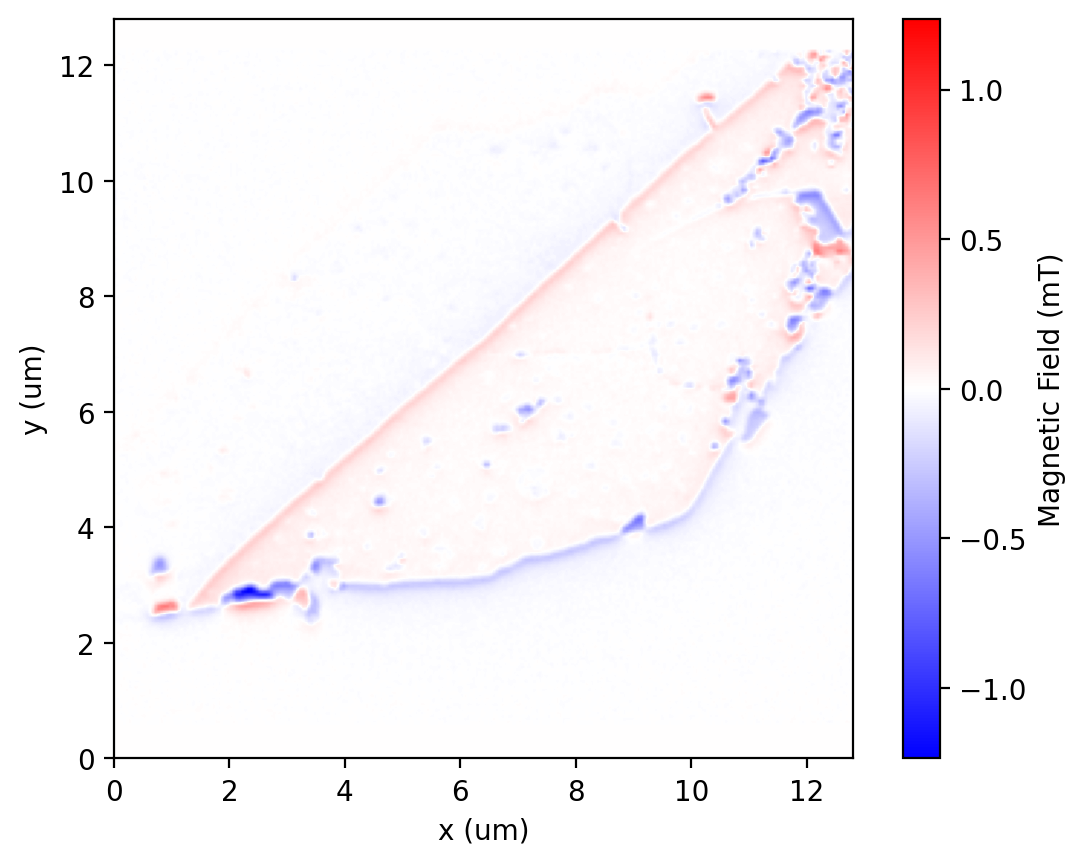

In [4]:
f = open(__datapath__ / "experimental" / "Magnetisation out of plane" / "CrI3_Exp_B_20180525_001.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] * 1e6

sensor_theta = 56
sensor_phi = 191

dataset = Data()
dataset.load_data(BNV, dx, dy, 0.035, sensor_theta, sensor_phi, 0)

dataset.remove_DC_background()
dataset.add_hanning_filter(0.05)
dataset.crop_data([0,256,0,256])
dataset.pad_data_to_power_of_two()

dataset.plot_target()

In [5]:
dataset.actions

,action type,reverseable,reverse action,description,parameters
0,load_data,False,None,loaded the data,None
1,remove_DC_background,False,None,Removed the DC background from the data,None
2,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 0.05
3,crop_data,False,crop_data,crop the data with the given region of interest,"roi = [0,256,0,256,]"
4,pad_data,True,crop_data,Padded the data to a square image with dimensi...,None


# Defining a wieght mask for fitting

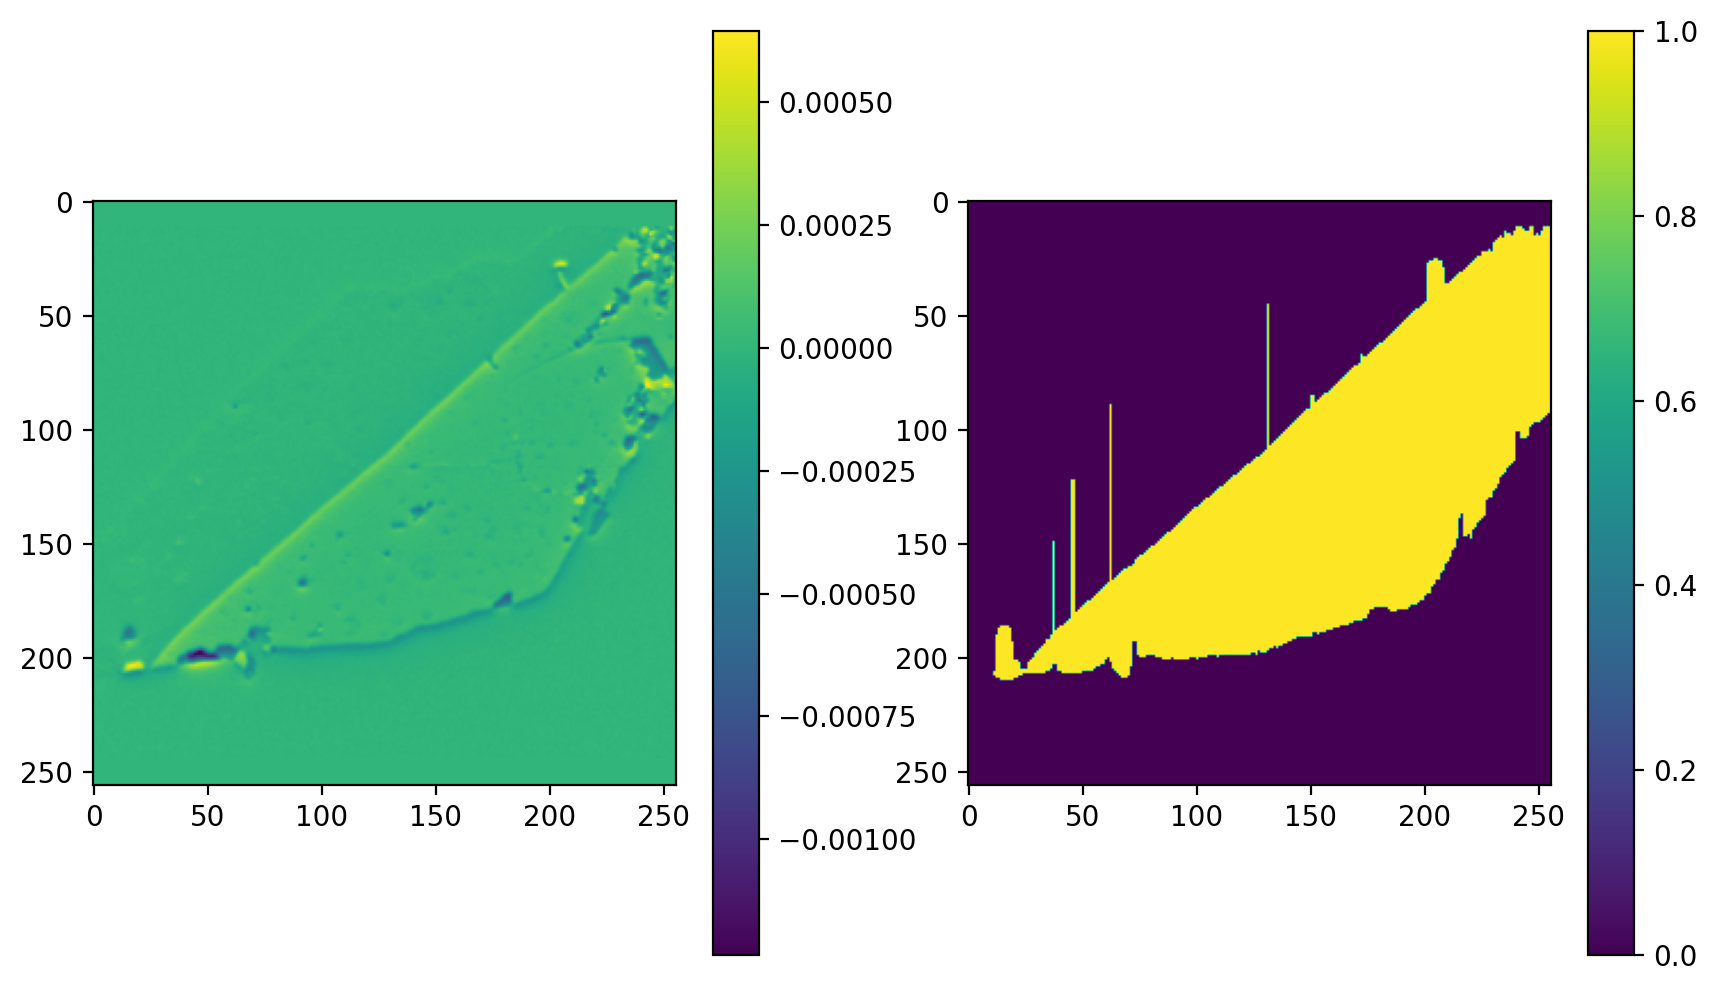

In [6]:
import scipy as sp


def mask_vert_dir(image, threshold):

    image = np.abs(image)
    wieght_mask = np.ones(image.size())
    img_size = image.shape 


    for idx in range(img_size[1]):
        for idx2 in range(img_size[0]):
            if image[-idx2, idx] > threshold:
                break
            wieght_mask[-idx2, idx] = 0 

        for idx2 in range(img_size[0]):
            if image[idx2,idx] > threshold:
                break
            wieght_mask[idx2,idx] = 0 
    return wieght_mask


threshold = 0.8e-4
wieght_mask = mask_vert_dir(dataset.target, threshold)

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(16)

plt.subplot(1,3,2)
plt.imshow(dataset.target)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(wieght_mask, vmin = 0, vmax = 1)
plt.colorbar()

weight = torch.from_numpy(wieght_mask)

## Now we will try to reconstruct the magnetisation using a neural network.

In [7]:
from magrec.method.CNN import CNN
from magrec.models.UniformMagnetisation import UniformMagnetisation

Model = UniformMagnetisation(dataset, "L1", m_theta = 0, m_phi = 0)
FittingMethod = CNN(Model, dataset)
FittingMethod.prepare_fit()

Number of sources: 1
Number of targets: 1


In [8]:
FittingMethod.fit(n_epochs=100, weight = weight)

epoch     1 | loss on last mini-batch:  2.79e-05
epoch    11 | loss on last mini-batch:  2.75e-05
epoch    21 | loss on last mini-batch:  2.60e-05
epoch    31 | loss on last mini-batch:  2.21e-05
epoch    41 | loss on last mini-batch:  1.89e-05
epoch    51 | loss on last mini-batch:  1.67e-05
epoch    61 | loss on last mini-batch:  1.51e-05
epoch    71 | loss on last mini-batch:  1.39e-05
epoch    81 | loss on last mini-batch:  1.31e-05
epoch    91 | loss on last mini-batch:  1.25e-05


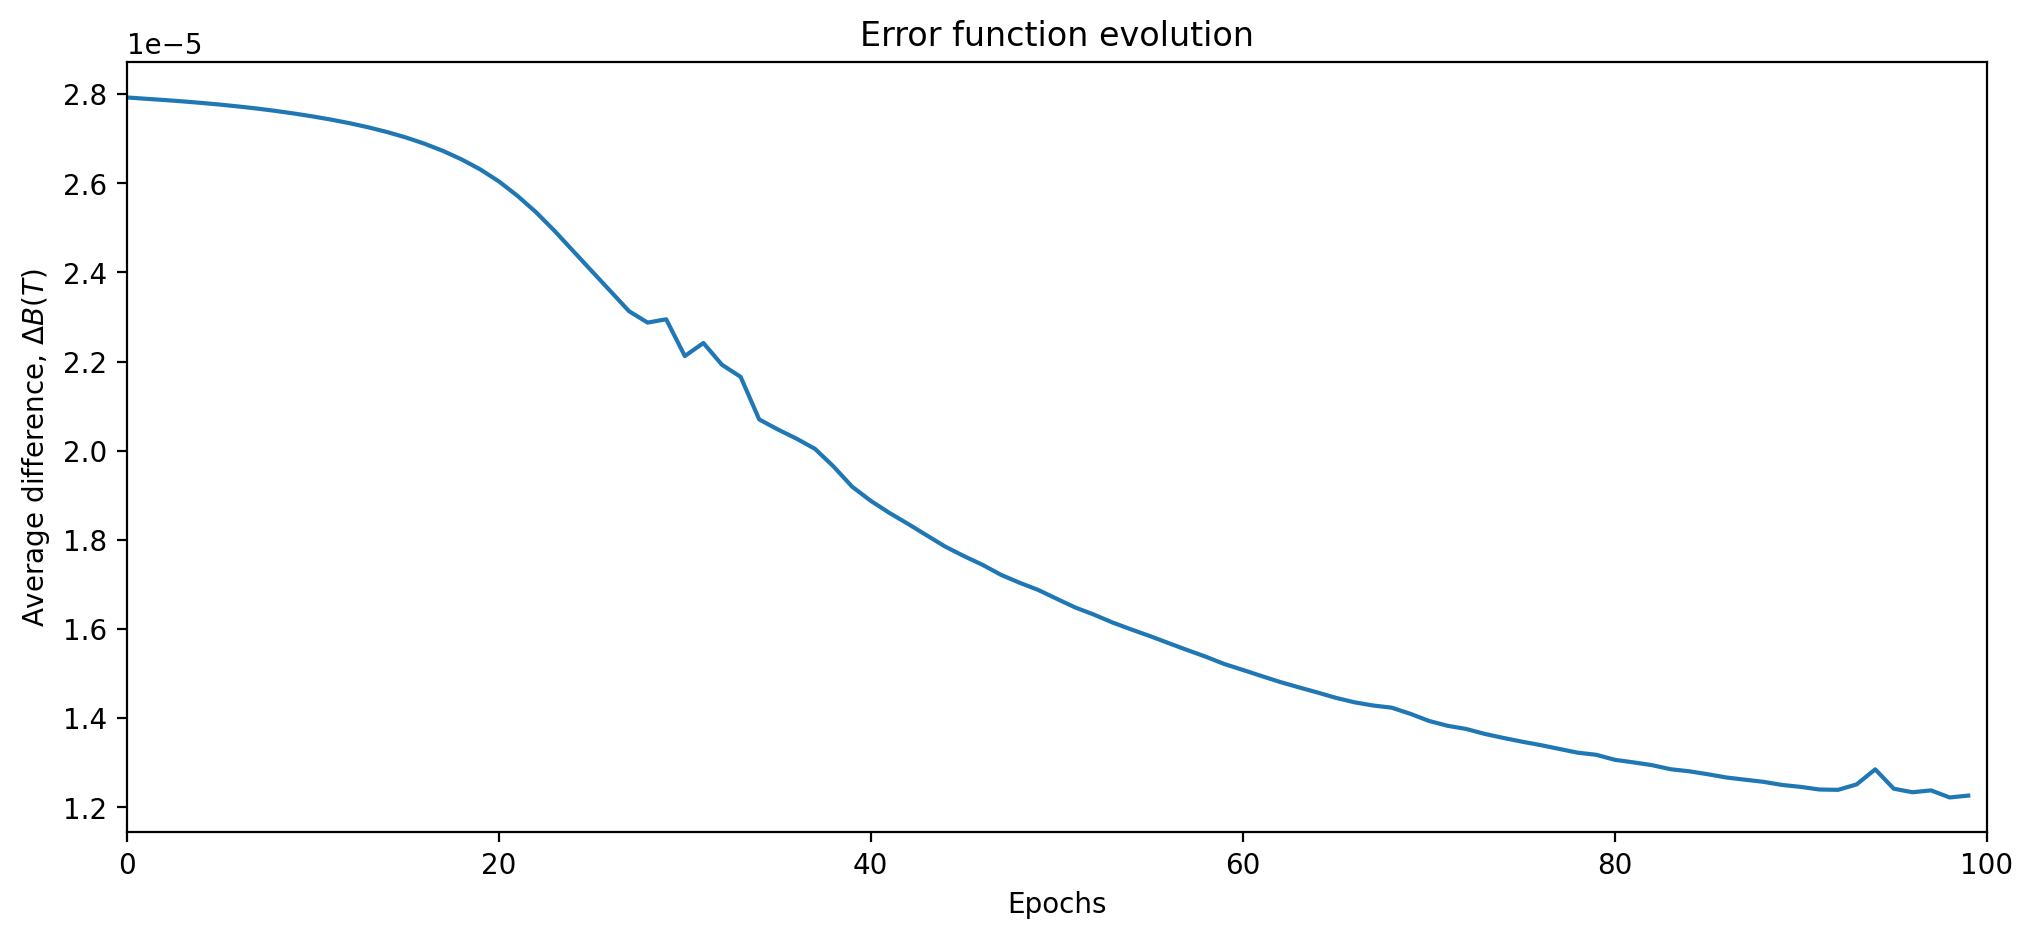

In [9]:
FittingMethod.plot_loss()

Removed the padding that was applied to the data


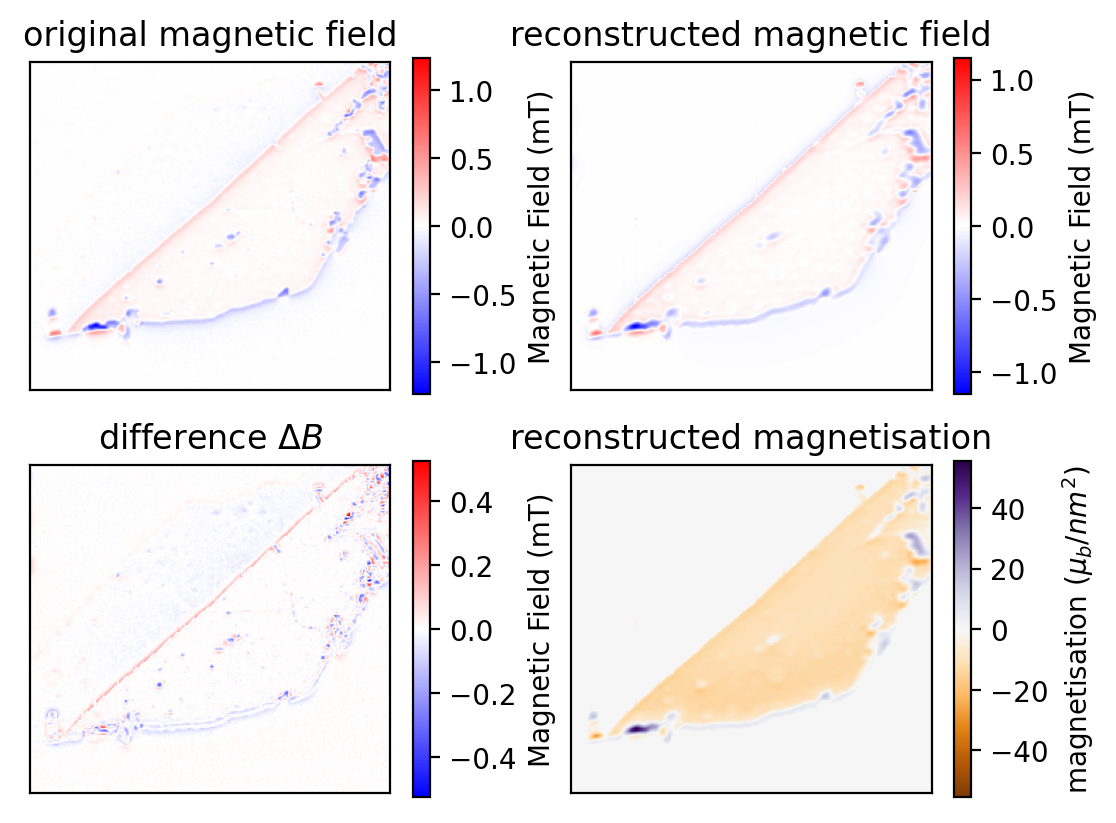

In [10]:
FittingMethod.plot_results()